In [102]:
from platform import python_version
print(python_version())
%pylab inline
import pickle
#pip install git+https://github.com/dwaithe/nanosimpy
#pip install tifffile
#pip install multipletau



3.7.4
Populating the interactive namespace from numpy and matplotlib


In [36]:
import tifffile
from lmfit import minimize, Parameters,report_fit,report_errors, fit_report
from nanosimpy import equations_to_fit as eq
def correlate_linear(a, b):
    """Return linear correlation of two vectors using DFT."""
    size = a.size
    
    # subtract mean and pad with zeros to twice the size
    a_mean = a.mean()
    b_mean = b.mean()
    
    #Has the padding in
    a = np.pad(a-a_mean, a.size//2, mode='constant')
    b = np.pad(b-b_mean, b.size//2, mode='constant')
    
    # forward DFT
    a = np.fft.rfft(a)
    b = np.fft.rfft(b)
    # multiply by complex conjugate
    c = a * b.conj()
    # reverse DFT
    c = np.fft.irfft(c)
    # positive delays only
    c = c[:size // 2]
        
    # normalize with the averages of a and b
    c /= size * a_mean * b_mean
    
    return c

In [115]:
data_array = tifffile.imread('out_img_D_0p5_noi_0_drift_False_ts_30000_mol_120_bleach_False_prob_0_1_.tif').astype(np.float64)
file = open('important', 'rb')

# dump information to that file
file_dict = pickle.load(file)
data_array = file_dict['trace'][0]

# close the file
file.close()
print(file_dict)

{'FWHMs': array([250]), 'pixel_size': 1.0, 'ri': array([0.000e+00, 1.000e+00, 2.000e+00, ..., 3.997e+03, 3.998e+03,
       3.999e+03]), 'number_FWHMs': 1, 'V': {0: array([1.00000000e+000, 9.99955640e-001, 9.99822570e-001, ...,
       1.61247548e-308, 1.13099866e-308, 7.93217947e-309])}, 'trace': {0: array([16.31343902, 16.93867754, 16.9437839 , ..., 21.25105132,
       21.6562114 , 21.72524042])}}


1


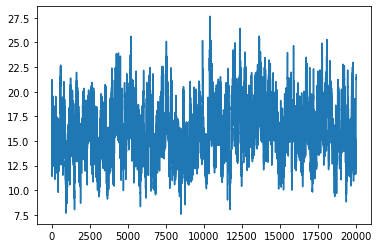

In [120]:
#Our file contains 64 intensity time series. 


time_step = 1 #ms
print(time_step)
data = data_array#[:,38]
_time = np.arange(data_array.shape[0])*time_step
plot(_time,data)

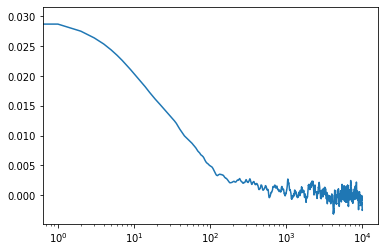

In [124]:
out = correlate_linear(data, data)
_time_corr = np.arange(out.shape[0])*time_step
semilogx(_time_corr,out)

residual 0.00787875781742104


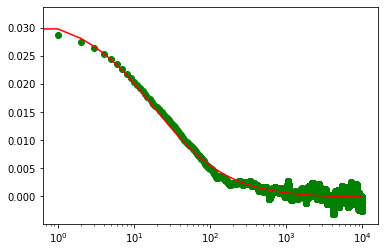

In [125]:
param = Parameters()
param.add('offset', value=0.01, min=-0.5, max=1.5, vary=True);
param.add('GN0', value=1.500, min=-0.0001, max=3000.0, vary=True);
param.add('offset', value=0.01, min=-0.5, max=1.5, vary=True);
param.add('A1', value=1.000, min=0.0001, max=1.0000, vary=False);
param.add('txy1',value=0.10, min=0.001, max=2000.0, vary=True);
param.add('alpha1',value=0.75, min=0.600, max=2.0, vary=True);
options = {'Dimen':1,'Diff_eq':1,'Triplet_eq':1,'Diff_species':1}

res = minimize(eq.residual, param, args=(_time_corr,out, options))
residualVar = res.residual
output = fit_report(res.params)
print ('residual',res.chisqr)
semilogx(_time_corr,out,'go')
semilogx(_time_corr,eq.equation_(res.params,_time_corr,options),'r')



In [67]:
res.params

name,value,standard error,relative error,initial value,min,max,vary
offset,-0.00233402,1.5217e-04,(6.52%),0.01,-0.50000000,1.50000000,True
GN0,0.84907541,0.01004556,(1.18%),1.5,-1.0000e-04,3000.00000,True
A1,1.00000000,0.00000000,(0.00%),1.0,1.0000e-04,1.00000000,False
txy1,14.6319896,0.36558187,(2.50%),0.1,1.0000e-03,2000.00000,True
alpha1,1.25232195,0.01478549,(1.18%),0.75,0.60000000,2.00000000,True


In [126]:
 print('D ',((1.0/np.sqrt(2.0*np.log(2.0)))*float(file_dict['FWHMs'][0])/1000.0)**2/(4*res.params['txy1'].value)*1000.0)

    

D  0.6195990964954493
